<a href="https://colab.research.google.com/github/pjv2122-cloud/class2/blob/main/contract_an.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Analysis of a Credit Agreement
contract = files.upload()


In [ ]:
# PDF Reader
!pip install PyMuPDF scikit-learn matplotlib pandas

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(freqs.head(15)['term'], freqs.head(15)['count'])
plt.xticks(rotation=45, ha='right')
plt.title("Top Terms (Excluding Numbers)")
plt.tight_layout()
plt.show()


In [ ]:
# Second analysis, excluding numbers
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt

# Custom tokenizer to exclude numeric tokens
def custom_tokenizer(text):
    # captures only alphabetic words with at least 2 letters
    return re.findall(r'\b[a-zA-Z]{2,}\b', text)

# Term Frequency
cv = CountVectorizer(stop_words='english', tokenizer=custom_tokenizer)
X = cv.fit_transform(df['clean'])

terms = np.array(cv.get_feature_names_out())
counts = np.asarray(X.sum(axis=0)).ravel()

freqs = pd.DataFrame({'term': terms, 'count': counts})
freqs = freqs.sort_values('count', ascending=False).reset_index(drop=True)

# Top 20 non-numeric terms
print("Top terms (excluding numbers):")
display(freqs.head(20))

# Plot
plt.figure(figsize=(8,4))
plt.bar(freqs.head(15)['term'], freqs.head(15)['count'])
plt.xticks(rotation=45, ha='right')
plt.title("Top Terms (Excluding Numbers)")
plt.tight_layout()
plt.show()

# (Top Weighted Terms)
tfidf = TfidfVectorizer(stop_words='english', tokenizer=custom_tokenizer)
X_tfidf = tfidf.fit_transform(df['clean'])

terms_tfidf = np.array(tfidf.get_feature_names_out())
scores = np.asarray(X_tfidf.sum(axis=0)).ravel()

tfidf_df = pd.DataFrame({'term': terms_tfidf, 'tfidf_sum': scores})
tfidf_df = tfidf_df.sort_values('tfidf_sum', ascending=False).reset_index(drop=True)

print("Top TF–IDF terms (excluding numbers):")
display(tfidf_df.head(20))

# Export
freqs.to_csv("term_frequencies_no_numbers.csv", index=False)
tfidf_df.to_csv("tfidf_terms_no_numbers.csv", index=False)


Using existing variable `text` from memory.
Preview: Execution Version    BA0.225477    CREDIT AGREEMENT    between      THE BORROWER LISTED ON EXHIBIT A  as Borrower      and        UNITED STATES DEPARTMENT OF THE TREASURY,  as Lender        Dated as of April 7, 2009          CONTENTS  Page  Article 1  Definitions...................................................................................................... 1  Section 1.01  Defined Terms .................................................................................... 1  Section 1.02  Other Definitional Provisions ............................................................. 9  Article 2  Amount and Terms of Commitments ....................................................... 10  Section 2.01  Commitments.............................................................................. ...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


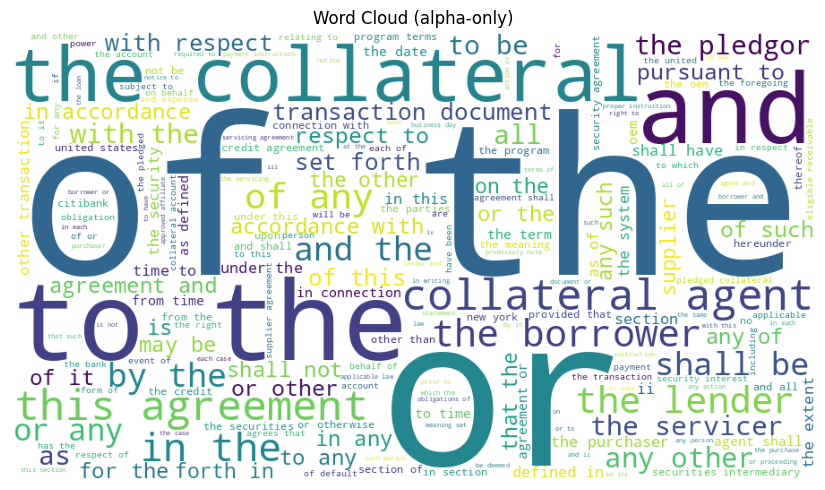

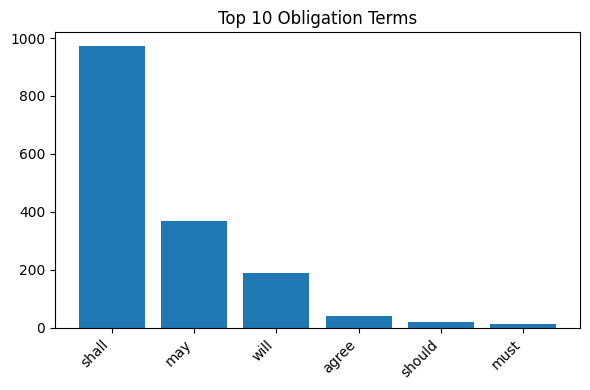

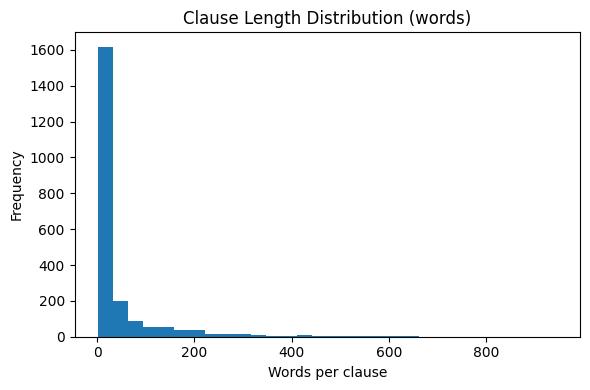

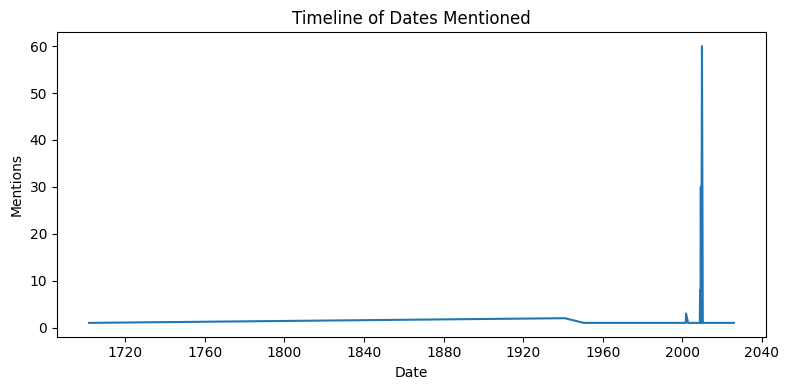

=== Done. CSVs written to ./outputs ===
{
  "n_clauses": 2185,
  "avg_words_per_clause": 40.31075514874142,
  "overall_ttr": 0.034571237184800006,
  "flesch_kincaid_grade": 20.02354055572835,
  "gunning_fog": 23.77688277500251,
  "top_obligation": "shall",
  "n_topics": 5,
  "n_all_caps_terms": 375,
  "quoted_definitions_found": 65
}


,clause_id,top_terms,top_scores
0,1,"version, execution","0.781, 0.624"
1,2,"borrower, listed, treasury, department, dated","0.399, 0.393, 0.309, 0.309, 0.297"
2,3,"contents, page","0.774, 0.633"
3,4,article,1.000
4,5,definitions,1.000
5,7,section,1.000
6,9,"defined, terms","0.752, 0.659"
7,11,section,1.000
8,13,"definitional, provisions","0.850, 0.527"
9,15,article,1.000


In [ ]:
# Legal Text Analytics — Credit Contract
# Third section

#  0) Setup
!pip -q install PyMuPDF textstat wordcloud scikit-learn matplotlib pandas python-dateutil spacy

import os, re, json, math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from wordcloud import WordCloud
import textstat
from dateutil import parser as dateparser
import fitz  # PyMuPDF

# Try to enable spaCy small model (optional)
try:
    import spacy, sys, subprocess
    if not spacy.util.is_package("en_core_web_sm"):
        _ = subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm", "-q"], check=False)
    nlp = spacy.load("en_core_web_sm")
except Exception:
    nlp = None
    print("spaCy small model not available; proceeding without NER.")


#  1) Ingest
def read_contract_text():
    # 1) Existing variable `text`
    if 'text' in globals() and isinstance(text, str) and len(text.strip()) > 0:
        print("Using existing variable `text` from memory.")
        return text
    # 2) Contract.txt
    if os.path.exists("Contract.txt"):
        with open("Contract.txt", "r", encoding="utf-8", errors="ignore") as f:
            print("Loaded Contract.txt")
            return f.read()
    # 3) Contract.pdf
    if os.path.exists("Contract.pdf"):
        print("Extracting text from Contract.pdf ...")
        doc = fitz.open("Contract.pdf")
        parts = [p.get_text("text") for p in doc]
        return "\n".join(parts)
    raise FileNotFoundError("Could not find `text`, Contract.txt, or Contract.pdf in the working directory.")

raw_text = read_contract_text()
print("Preview:", raw_text[:800].replace("\n"," ")[:800], "...")


#  2) Preprocess & Clause Extraction
def normalize_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

clean_text = normalize_spaces(raw_text)

# Split at common legal markers (Article/Section/Clause/Paragraph, numbered headings 1., 1.1, etc.)
split_pattern = r"(?i)(?=\b(?:article|section|clause|paragraph)\s+\d+[\w-]*\b|\b\d+(?:\.\d+)*\s+)"
clauses = re.split(split_pattern, clean_text)
clauses = [c.strip() for c in clauses if c.strip()]

df = pd.DataFrame({"clause_id": range(1, len(clauses)+1), "text": clauses})

def clean_for_analysis(t: str) -> str:
    t = t.lower()
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

df["clean"] = df["text"].apply(clean_for_analysis)
df["word_count"] = df["clean"].str.split().apply(len)


# 3) Obligation Intensity
OBLIGATION_TERMS = ["shall", "must", "agree", "will", "should", "may"]

def count_terms(s: str, terms):
    tokens = s.split()
    freq = {t: 0 for t in terms}
    for tok in tokens:
        if tok in freq:
            freq[tok] += 1
    return freq

df_obl = df["clean"].apply(lambda s: count_terms(s, OBLIGATION_TERMS)).apply(pd.Series)
df_obl["clause_id"] = df["clause_id"]
obl_totals = df_obl[OBLIGATION_TERMS].sum().sort_values(ascending=False)
obl_totals_df = obl_totals.reset_index()
obl_totals_df.columns = ["term", "count"]


# 4) Lexical Diversity & Readability
def ttr(s: str) -> float:
    toks = s.split()
    return (len(set(toks)) / len(toks)) if toks else 0.0

df["ttr"] = df["clean"].apply(ttr)

overall_ttr = ttr(" ".join(df["clean"]))
fk_grade = textstat.flesch_kincaid_grade(clean_text)
gunning_fog = textstat.gunning_fog(clean_text)

readability_stats = pd.DataFrame([
    {"metric": "overall_ttr", "value": overall_ttr},
    {"metric": "flesch_kincaid_grade", "value": fk_grade},
    {"metric": "gunning_fog", "value": gunning_fog},
])


#  5) Topic Modeling (NMF over TF–IDF, exclude numbers)
def alpha_tokenizer(text):
    # only alphabetic words with 2+ letters; excludes digits/numbers
    return re.findall(r"\b[a-zA-Z]{2,}\b", text)

tfidf = TfidfVectorizer(stop_words="english", tokenizer=alpha_tokenizer, min_df=2)
X_tfidf = tfidf.fit_transform(df["clean"])  # (n_clauses x n_terms)

n_topics = 5  # adjust if needed
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvda", max_iter=500)
W = nmf.fit_transform(X_tfidf)
H = nmf.components_
terms = np.array(tfidf.get_feature_names_out())

topn = 10
topic_terms = []
for k in range(n_topics):
    idx = np.argsort(-H[k])[:topn]
    topic_terms.append(", ".join(terms[idx]))
topics_df = pd.DataFrame({"topic": range(n_topics), "top_terms": topic_terms})

df["topic"] = W.argmax(axis=1)


# 6) Defined Terms Detection
ALLCAPS = sorted(set(re.findall(r"\b[A-Z]{2,}\b", raw_text)))
quoted_defs = re.findall(r"[\"']([A-Z][A-Za-z0-9 _-]{1,50})[\"']\s+(?:shall\s+mean|means)\b", raw_text)

defined_terms_df = pd.DataFrame({
    "n_all_caps": [len(ALLCAPS)],
    "n_quoted_definitions": [len(quoted_defs)],
    "sample_all_caps": [", ".join(ALLCAPS[:50]) + (" ..." if len(ALLCAPS) > 50 else "")],
})
defined_terms_sample = pd.DataFrame({"quoted_term": quoted_defs[:50]})


# 7) Visualizations
# 7.1 Word Cloud (alpha-only)
def alpha_only(text):
    return " ".join(re.findall(r"\b[a-zA-Z]{2,}\b", text))

wc_text = alpha_only(" ".join(df["clean"]))
if wc_text.strip():
    wc = WordCloud(width=900, height=500, background_color="white", stopwords=set()).generate(wc_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title("Word Cloud (alpha-only)")
    plt.tight_layout()
    plt.show()
else:
    print("Word cloud text empty after filtering; skipping.")

# 7.2 Bar Chart — Top 10 Obligations
top10 = obl_totals_df.head(10)
plt.figure(figsize=(6,4))
plt.bar(top10["term"], top10["count"])
plt.title("Top 10 Obligation Terms")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 7.3 Clause Length Histogram
plt.figure(figsize=(6,4))
plt.hist(df["word_count"], bins=30)
plt.title("Clause Length Distribution (words)")
plt.xlabel("Words per clause")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 7.4 Timeline of Dates Mentioned (only if enough dates parsed)
date_patterns = [
    r"\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{1,2},\s+\d{4}\b",
    r"\b\d{1,2}/\d{1,2}/\d{2,4}\b",
    r"\b\d{4}-\d{1,2}-\d{1,2}\b",
    r"\b\d{4}\b",
]
found = []
for patt in date_patterns:
    found += re.findall(patt, raw_text, flags=re.I)

parsed_dates = []
for d in found:
    try:
        parsed_dates.append(pd.to_datetime(dateparser.parse(d, fuzzy=True)))
    except Exception:
        pass

if len(parsed_dates) >= 5:
    ser = pd.Series(parsed_dates).dt.date.value_counts().sort_index()
    plt.figure(figsize=(8,4))
    plt.plot(ser.index, ser.values)
    plt.title("Timeline of Dates Mentioned")
    plt.xlabel("Date")
    plt.ylabel("Mentions")
    plt.tight_layout()
    plt.show()
else:
    print(f"Not enough parsed dates for a timeline (found {len(parsed_dates)} < 5).")


# 8) Exports (deliverable layer)
outdir = "outputs"
os.makedirs(outdir, exist_ok=True)

df.to_csv(f"{outdir}/contract_clauses.csv", index=False)
df_obl.to_csv(f"{outdir}/obligation_by_clause.csv", index=False)
obl_totals_df.to_csv(f"{outdir}/obligation_totals.csv", index=False)
readability_stats.to_csv(f"{outdir}/readability_stats.csv", index=False)
topics_df.to_csv(f"{outdir}/topics_top_terms.csv", index=False)
df[["clause_id", "topic", "text"]].to_csv(f"{outdir}/clause_topics.csv", index=False)
defined_terms_df.to_csv(f"{outdir}/defined_terms_overview.csv", index=False)
defined_terms_sample.to_csv(f"{outdir}/quoted_definitions_sample.csv", index=False)

summary = {
    "n_clauses": int(len(df)),
    "avg_words_per_clause": float(df["word_count"].mean()) if len(df) else 0.0,
    "overall_ttr": float(overall_ttr),
    "flesch_kincaid_grade": float(fk_grade),
    "gunning_fog": float(gunning_fog),
    "top_obligation": str(obl_totals_df.iloc[0]["term"]) if len(obl_totals_df) else "",
    "n_topics": int(len(topics_df)),
    "n_all_caps_terms": int(len(ALLCAPS)),
    "quoted_definitions_found": int(len(quoted_defs)),
}
pd.DataFrame([summary]).to_csv(f"{outdir}/deliverable_summary.csv", index=False)

print("=== Done. CSVs written to ./outputs ===")
print(json.dumps(summary, indent=2))

# 9) (Optional) Clause-level top-k TF–IDF keywords
# produces a compact table of the top 5 distinctive terms per clause
def top_k_tfidf_per_doc(X, terms_arr, k=5):
    rows = []
    for i in range(X.shape[0]):
        row = X.getrow(i).toarray().ravel()
        nz = row > 0
        if not nz.any():
            continue
        idx = np.argsort(-row[nz])[:k]
        rows.append({
            "clause_id": i+1,
            "top_terms": ", ".join(terms_arr[nz][idx]),
            "top_scores": ", ".join([f"{v:.3f}" for v in row[nz][idx]]),
        })
    return pd.DataFrame(rows)

clause_top = top_k_tfidf_per_doc(X_tfidf, terms, k=5)
clause_top.to_csv(f"{outdir}/clause_top5_tfidf.csv", index=False)
clause_top.head(10)


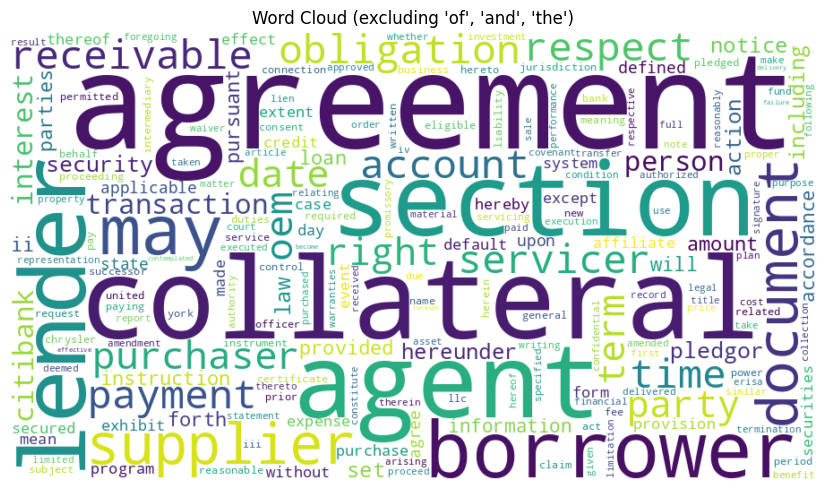

In [ ]:
# Improved Word Cloud (removes "of", "and", "the")
from wordcloud import WordCloud, STOPWORDS

# create a custom stopword list
custom_stops = set(STOPWORDS)
custom_stops.update(["of", "and", "the"])

def alpha_only(text):
    """Return only alphabetic words, removing numbers and punctuation."""
    return " ".join(re.findall(r"\b[a-zA-Z]{2,}\b", text))

wc_text = alpha_only(" ".join(df["clean"]))

if wc_text.strip():
    wc = WordCloud(
        width=900,
        height=500,
        background_color="white",
        stopwords=custom_stops,
        collocations=False
    ).generate(wc_text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud (excluding 'of', 'and', 'the')")
    plt.tight_layout()
    plt.show()
else:
    print("Word cloud text empty after filtering; skipping.")
